In [1]:
#Library import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests


In [19]:
#1-2. Python을 사용하여 API를 호출하는 코드를 작성하고, 2015년 1월부터 2024년 12월까지의 개
#인 유형의 현년 전기, 가스, 수도, 지역난방 에너지 사용량 데이터를 수집하는 프로그램을 작성하
#시오. API 호출 성공을 확인할 수 있는 실행 결과를 캡처하여 첨부하시오. (7점)

year_list  = [str(y) for y in range(2015, 2025)]
month_list = [f"{m:02d}" for m in range(1, 13)]
api_key    = "4547454c5a6c736338324a42614146"

cols = ['YEAR','MON','MM_TYPE','EUS','GUS','WUS','HUS']

df_total = pd.DataFrame(columns=cols)

for year in year_list:
    for month in month_list:
        url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/1/5/{year}/{month}"
        try:
            params = {
                "KEY": api_key,
                "TYPE": "json",
                "SERVICE": "energyUseDataSummaryInfo",
            }
            response = requests.get(url, params=params, timeout=10)

            if response.status_code == 200:             
                print("api 호출 성공")
                print(response.json())
            else:
                print(f"API 호출 실패: {response.status_code}")
            
            data = response.json()
            
            # 응답 형식/오류 체크
            svc = data.get('energyUseDataSummaryInfo', {})
            result = svc.get('RESULT', {})
            if result.get('CODE') not in (None, 'INFO-000'):
                print(f"[SKIP] {year}-{month}: API RESULT={result}")
                continue

            rows = svc.get('row', [])
            if not rows:
                print(f"[SKIP] {year}-{month}: no rows")
                continue

            # "MM_TYPE" == "개인" 인 항목만 남기기
            rows = [r for r in rows if r.get("MM_TYPE") == "개인"]

            # 필터 결과가 비면 스킵 처리
            if not rows:
                print(f"[SKIP] {year}-{month}: no '개인' rows")
                continue

            #2-1. 수집한 JSON 형태의 데이터를 pandas DataFrame으로 변환하고, 데이터의 기본 정보를 출력
            #하는 코드와 실행 결과를 첨부하시오. (4점)
            
            #수집한 데이터를 DataFrame으로 변환
            df = pd.DataFrame(rows)

            # 원하는 컬럼만 사용(없으면 NaN으로 채움) + 순서 고정
            df = df.reindex(columns=cols)

            # 증분 결합 (원본 갱신)
            df_total = pd.concat([df_total, df], ignore_index=True)

        except Exception as e:
            print(f"[ERR] {year}-{month}: {e}")

# 데이터 자료형 변환
df_total[['EUS','GUS','WUS','HUS']] = df_total[['EUS','GUS','WUS','HUS']].astype(float)

api 호출 성공
{'energyUseDataSummaryInfo': {'list_total_count': 7, 'RESULT': {'CODE': 'INFO-000', 'MESSAGE': '정상 처리되었습니다'}, 'row': [{'YEAR': '2015', 'MON': '01', 'MM_TYPE': '개인', 'CNT': '767791', 'EUS': '193784708', 'EUS1': '194781915', 'EUS2': '204969429', 'ECO2_1': '-6090964', 'ECO2_2': '-2582568.736', 'GUS': '59133720', 'GUS1': '57163993', 'GUS2': '68297619', 'GCO2_1': '-3597086', 'GCO2_2': '-8057472.64', 'WUS': '12819757.886', 'WUS1': '12723680.426', 'WUS2': '12899476.73', 'WCO2_1': '8179.308', 'WCO2_2': '2715.530256', 'HUS': '22740838.937', 'HUS1': '23400055.303', 'HUS2': '27090493.875', 'HCO2_1': '-2504435.652', 'HCO2_2': '-33660084.213069', 'REG_DATE': '2015-06-04 17:03:55.0'}, {'YEAR': '2015', 'MON': '01', 'MM_TYPE': '학교', 'CNT': '1382', 'EUS': '134955565', 'EUS1': '128707423', 'EUS2': '145561511', 'ECO2_1': '-2178902', 'ECO2_2': '-923854.448', 'GUS': '9107197', 'GUS1': '8410968', 'GUS2': '10745416', 'GCO2_1': '-470995', 'GCO2_2': '-1055028.8', 'WUS': '2075819.2', 'WUS1': '2097433.

In [20]:
# df_total 이 최종 통합본
# 데이터 기본정보 출력 코드
df_total.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     83 non-null     object 
 1   MON      83 non-null     object 
 2   MM_TYPE  83 non-null     object 
 3   EUS      83 non-null     float64
 4   GUS      83 non-null     float64
 5   WUS      83 non-null     float64
 6   HUS      83 non-null     float64
dtypes: float64(4), object(3)
memory usage: 4.7+ KB


In [21]:
df_total.shape

(83, 7)

In [22]:
df_total[['EUS','GUS','WUS','HUS']].describe()

,EUS,GUS,WUS,HUS
count,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01
mean,2.536563e+08,3.384333e+07,1.414308e+07,1.175129e+07
std,5.627379e+07,2.509535e+07,1.374423e+06,1.420605e+07
min,1.348281e+08,5.729131e+06,7.215169e+06,5.003383e+04
25%,2.210124e+08,1.098092e+07,1.374071e+07,1.485323e+06
50%,2.471430e+08,2.483589e+07,1.427311e+07,8.836296e+06
75%,2.683477e+08,5.556934e+07,1.493014e+07,2.001829e+07
max,4.639713e+08,8.849695e+07,1.661911e+07,1.061349e+08


In [23]:
#2-2. 연도별, 계절별 분석을 위해 날짜 컬럼을 활용하여 연도(year)와 계절(season) 컬럼을 추가하
#는 전처리 코드를 작성하고, 변환 결과를 확인할 수 있는 출력 결과를 첨부하시오.
#계절 구분: 봄(3-5월), 여름(6-8월), 가을(9-11월), 겨울(12-2월) (4점)"""

# 문자열 → 숫자 변환
df_total["MON"] = df_total["MON"].astype(int)

# 계절 분류 함수 정의
def get_season(m):
    if m in [3, 4, 5]:
        return "봄"
    elif m in [6, 7, 8]:
        return "여름"
    elif m in [9, 10, 11]:
        return "가을"
    else:  # 12, 1, 2
        return "겨울"

# 새 컬럼 생성
df_total["season"] = df_total["MON"].map(get_season)

df_total

,YEAR,MON,MM_TYPE,EUS,GUS,WUS,HUS,season
0,2015,1,개인,193784708.0,59133720.0,1.281976e+07,2.274084e+07,겨울
1,2015,2,개인,189974230.0,56487358.0,1.265689e+07,1.879332e+07,겨울
2,2015,5,개인,177289769.0,22060892.0,1.308673e+07,1.320896e+06,봄
3,2015,6,개인,186073153.0,12677645.0,1.424165e+07,2.943126e+05,여름
4,2015,7,개인,165114568.0,8893640.0,1.208388e+07,7.028636e+05,여름
...,...,...,...,...,...,...,...,...
78,2024,8,개인,463971328.0,7072251.0,1.587354e+07,1.300823e+05,여름
79,2024,9,개인,409872908.0,5729131.0,1.514332e+07,3.420507e+06,가을
80,2024,10,개인,282268119.0,8233421.0,1.529767e+07,2.695491e+06,가을
81,2024,11,개인,257927956.0,17418221.0,1.467867e+07,8.836296e+06,가을


Text(0.5, 1.0, 'Trend of Yearly Energy Consumption - 5746')

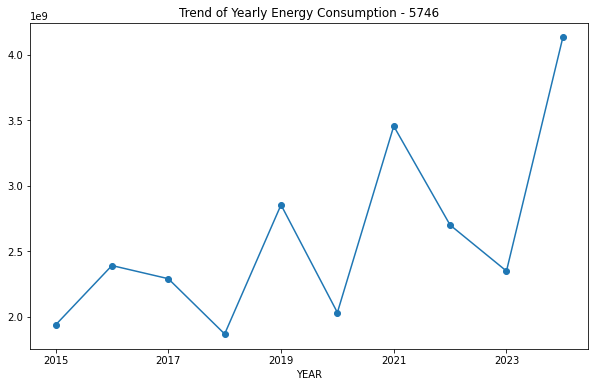

In [148]:
#문제 3. 데이터 시각화 (8점)
#전처리된 데이터를 활용하여 다음의 시각화를 수행하시오.
#3-1. 연도별 에너지 사용 총 사용량(전기+가스+수도+지역난방) 변화량을 선 그래프로 시각화하고,
#그래프에 자신의 학번 뒤 4자리를 제목에 포함하여 저장하시오. (예: "연도별 에너지 사용 총액 변
#화 - 1234") 시각화 코드와 생성된 그래프를 첨부하시오. (4점)

# 연도별 총 에너지 사용량 계산
df_total['total_usage'] = df_total[['EUS', 'GUS', 'WUS', 'HUS']].sum(axis=1)

df_yearly_total = df_total.groupby('YEAR')['total_usage'].sum()

plt.figure(figsize=(10, 6))
df_yearly_total.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Trend of Yearly Energy Consumption - 5746')


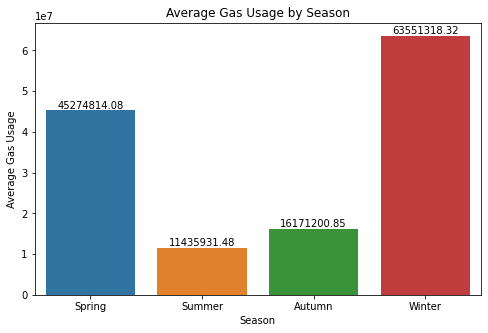

In [146]:
#3-2. 계절별 가스 사용량 평균을 막대 그래프로 시각화하고, 각 막대에 구체적인 수치를 표시하시
#오. 시각화 코드와 생성된 그래프를 첨부하시오. (4점)

#봄, 여름, 가을, 겨울 순서로 정렬
season_order = ["봄","여름","가을","겨울"]
df_total["season"] = pd.Categorical(df_total["season"], categories=season_order, ordered=True)

df_seasonal_GUS_avg = df_total.groupby('season')['GUS'].mean()


#시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=df_seasonal_GUS_avg.index, y=df_seasonal_GUS_avg.values)

#X축 각 계절값 영어로 변경
plt.xticks(ticks=range(4), labels=['Spring', 'Summer', 'Autumn', 'Winter'])
#Spring, Summer, Fall, Winter 순서로 정렬



#각 막대 위에 수치 표시
for i, v in enumerate(df_seasonal_GUS_avg.values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom')
plt.title('Average Gas Usage by Season')
plt.ylabel('Average Gas Usage')
plt.xlabel('Season')
plt.show()

In [ ]:
#문제 4. 데이터 분석 및 해석 (4점)
#시각화 결과를 바탕으로 다음을 분석하고 설명하시오.
#4. 연도별 에너지 사용량 변화에서 나타나는 주요 트렌드를 찾아 분석하고, 그 원인을 추론하여
#200자 이내로 설명하시오. (4점)

In [138]:
#연도, 계절별 에너지 사용량 평균

df_total_sum_by_year = df_total.groupby(['YEAR'])[['EUS', 'GUS', 'WUS', 'HUS']].sum().sum(axis=1).to_frame().rename(columns={0:'total_usage'})


In [139]:
df_total_sum_by_year

,total_usage
YEAR,
2015,1.937243e+09
2016,2.391015e+09
2017,2.290582e+09
2018,1.868486e+09
2019,2.854433e+09
2020,2.032166e+09
2021,3.455637e+09
2022,2.700390e+09
2023,2.349018e+09


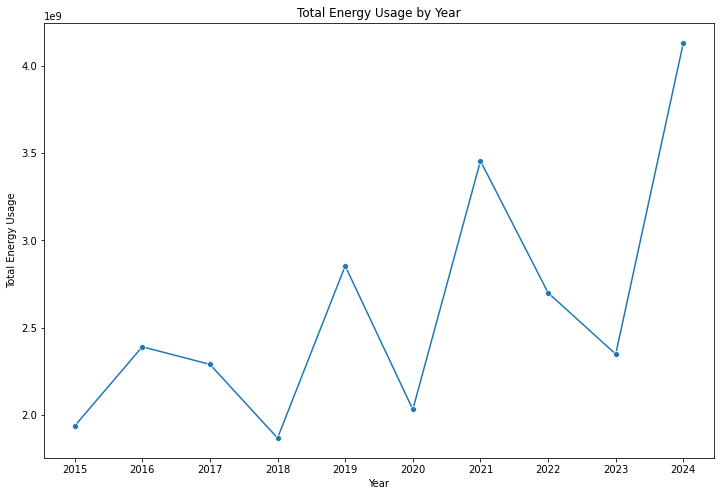

In [140]:
#시각화
df_total_sum_by_year.reset_index(inplace=True)
#계절명 영어로 map핑
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_total_sum_by_year, x='YEAR', y = 'total_usage', marker='o')
plt.title('Total Energy Usage by Year')
plt.ylabel('Total Energy Usage')
plt.xlabel('Year')
plt.show()

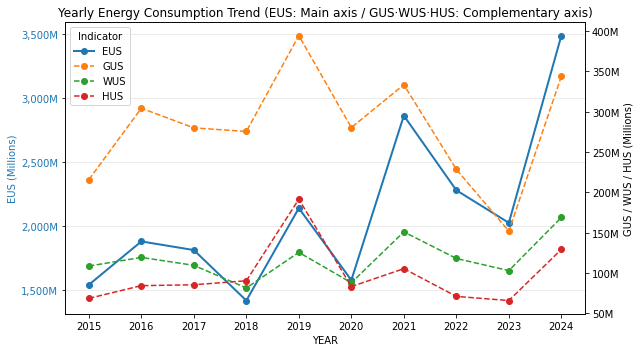

In [112]:
from matplotlib.ticker import FuncFormatter

df = df_total_sum_by_year.reset_index().copy()

# y축 포매터 (백만 단위)
fmt = FuncFormatter(lambda x, p: f"{int(x/1e6):,}M")

# Figure & Axis
fig, ax1 = plt.subplots(figsize=(9,5))

# ─────────────────────────────
# 1️⃣ 주축 (왼쪽): EUS
# ─────────────────────────────
ax1.plot(df["YEAR"], df["EUS"], color="tab:blue", marker="o", label="EUS", linewidth=2)
ax1.set_xlabel("YEAR")
ax1.set_ylabel("EUS (Millions)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.yaxis.set_major_formatter(fmt)
ax1.grid(True, axis="y", alpha=0.3)

# ─────────────────────────────
# 2️⃣ 보조축 (오른쪽): GUS, WUS, HUS
# ─────────────────────────────
ax2 = ax1.twinx()  # 보조축 생성

for col, color in zip(["GUS", "WUS", "HUS"], ["tab:orange", "tab:green", "tab:red"]):
    ax2.plot(df["YEAR"], df[col], marker="o", label=col, color=color, linestyle="--")

ax2.set_ylabel("GUS / WUS / HUS (Millions)", color="black")
ax2.yaxis.set_major_formatter(fmt)

# ─────────────────────────────
# 3️⃣ 범례 정리
# ─────────────────────────────
# 두 축의 legend 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", title="Indicator")

ax1.set_title("Yearly Energy Consumption Trend (EUS: Main axis / GUS·WUS·HUS: Complementary axis)")
plt.tight_layout()
plt.show()

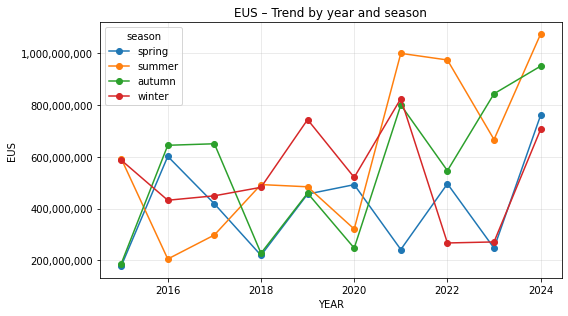

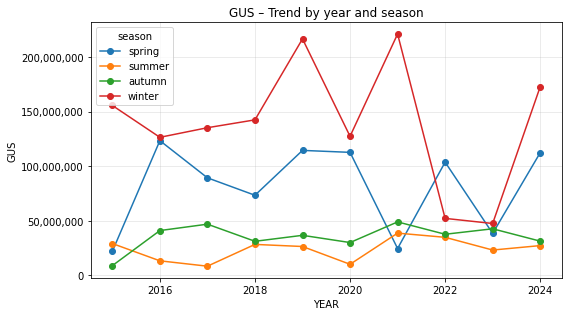

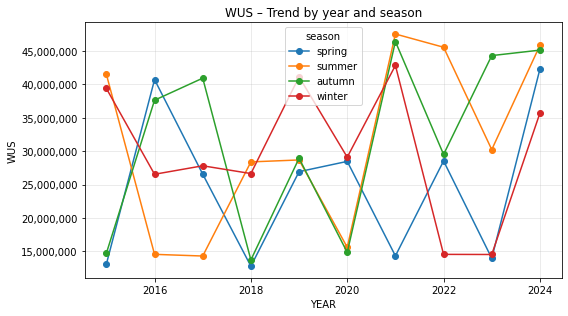

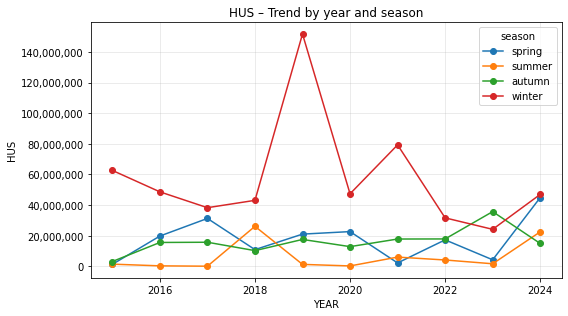

In [141]:
df2_total_sum_by_season = df_total.groupby(['YEAR', 'season'])[['EUS', 'GUS', 'WUS', 'HUS']].sum()

df2 = df2_total_sum_by_season.reset_index().copy()
#봄, 여름, 가을, 겨울 을 spring, summer, autumn, winter 로 변경
df2["season"] = df2["season"].map({"봄":"spring", "여름":"summer", "가을":"autumn", "겨울":"winter"})


# ─────────────────────────────
# 1) 전처리: season 순서 고정, 타입 정리
# ─────────────────────────────
season_order = ["spring","summer","autumn","winter"]
df2["season"] = pd.Categorical(df2["season"], categories=season_order, ordered=True)
df2["YEAR"] = df2["YEAR"].astype(int)

# y축 숫자 포매터 (천 단위 구분)
fmt = FuncFormatter(lambda x, p: f"{int(x):,}")

# ─────────────────────────────
# 2) 지표별 라인차트 (연도 × 계절 4라인)
# ─────────────────────────────
metrics = ["EUS","GUS","WUS","HUS"]

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for s in season_order:
        sub = df2[df2["season"] == s].sort_values("YEAR")
        ax.plot(sub["YEAR"], sub[metric], marker="o", label=s)

    ax.set_title(f"{metric} – Trend by year and season")
    ax.set_xlabel("YEAR")
    ax.set_ylabel(metric)
    ax.yaxis.set_major_formatter(fmt)
    ax.legend(title="season")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ─────────────────────────────
# 3) (선택) 히트맵: 연도(행) × 계절(열) 한눈 비교
# ─────────────────────────────
def plot_heatmap(df2, metric, season_order=season_order):
    # 피벗: index=YEAR, columns=season
    pv = df2.pivot_table(index="YEAR", columns="season", values=metric, aggfunc="sum")[season_order]
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(pv.values, aspect="auto")
    ax.set_xticks(range(len(pv.columns)))
    ax.set_xticklabels(pv.columns)
    ax.set_yticks(range(len(pv.index)))
    ax.set_yticklabels(pv.index)
    ax.set_title(f"{metric} – heatmap by year and season")
    # 값 라벨(선택)
    for i in range(pv.shape[0]):
        for j in range(pv.shape[1]):
            ax.text(j, i, f"{int(pv.values[i, j]):,}", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# 예시: EUS 히트맵을 한번에 보고 싶다면
# plot_heatmap(df2, "EUS")




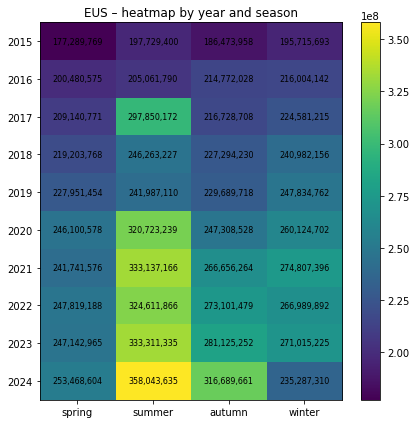

In [117]:
plot_heatmap(df2, "EUS")

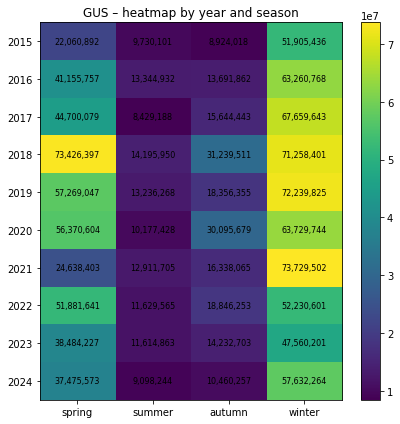

In [118]:
plot_heatmap(df2, "GUS")

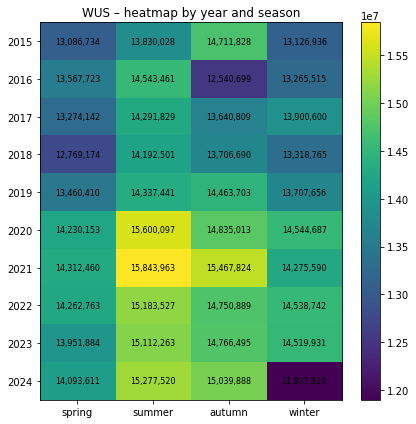

In [119]:
plot_heatmap(df2, "WUS")

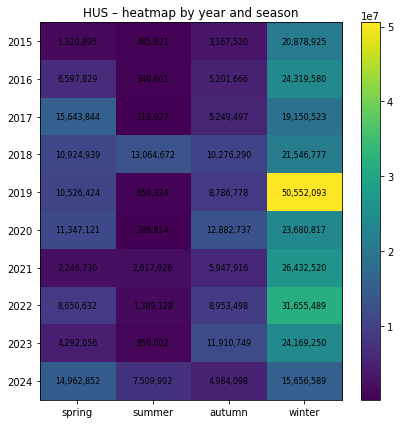

In [120]:
plot_heatmap(df2, "HUS")